# Lorentz attractor — Ensemble Kalman filter

In [62]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [318]:
@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        h = dt
        t = dt * i
        k1 = h * f(ys[i-1], t)
        k2 = h * f(ys[i-1] + k1/2., dt * i + h/2.)
        k3 = h * f(ys[i-1] + k2/2., t + h/2.)
        k4 = h * f(ys[i-1] + k3, t + h)

        ysi = ys[i-1] + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

## 3D loretz

In [319]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t, *args):
  x, y, z = state
  return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

N = 5_000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)

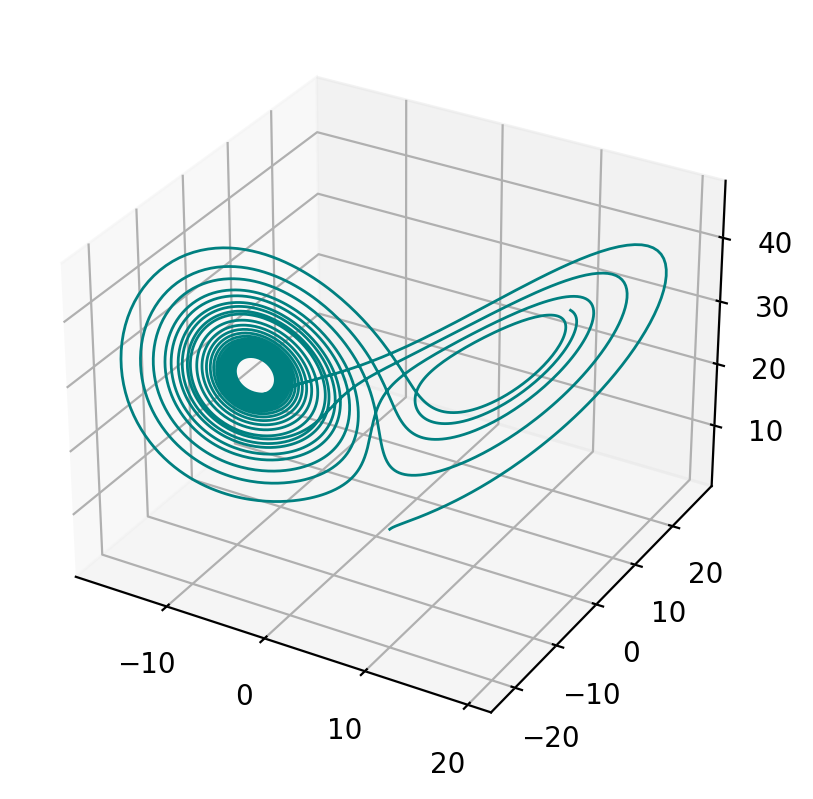

In [320]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")

# Modified Lorentz 96 model
See https://en.wikipedia.org/wiki/Lorenz_96_model


$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$
with 
* $F_k \sim {\cal N}(8, 1)$

In [603]:
from functools import partial

In [604]:
D = 40
ixs = jnp.arange(D)

key = jax.random.PRNGKey(31415)
key_init, key_sim = jax.random.split(key)
x0 = 8.0 + jax.random.uniform(key_init, (D,))

In [605]:
@partial(jax.vmap, in_axes=(None, 0))
def fcoord(x, k):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, *args):
    keyt = jax.random.fold_in(key_sim, t)
    F = jax.random.normal(keyt, shape=(D,))
    xdot = fcoord(x, ixs) + F + 8.0
    return xdot

In [620]:
N = 100
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, 0.01, N, f)

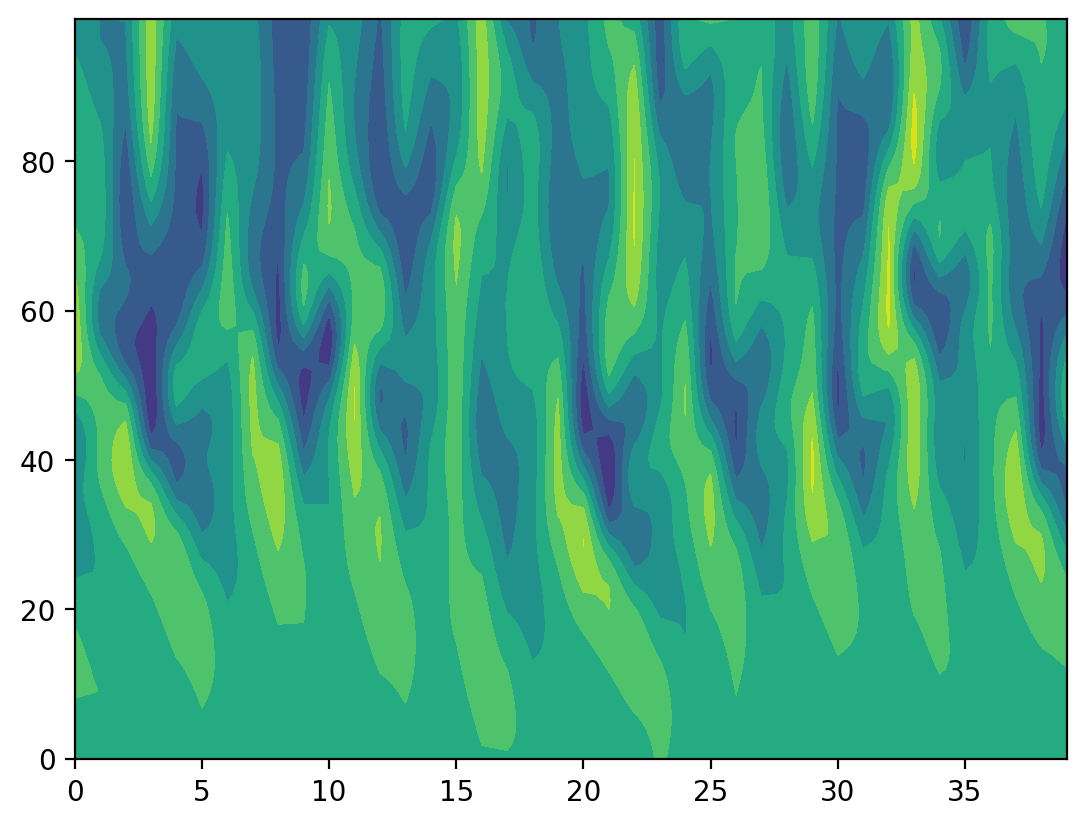

In [621]:
plt.contourf(xs)

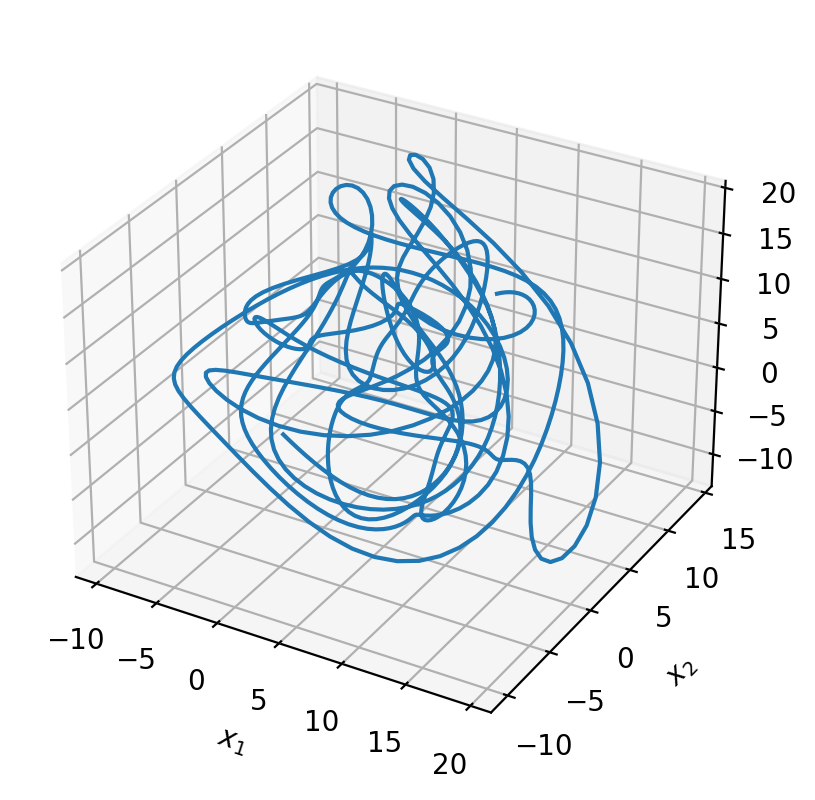

In [614]:
# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()